# 04-Data Preprocessing & Weight Initialization

[1.Data Preprocessing](#1)
  - [1-1.Centering](#1-1)
  - [1-2.Normalization](#1-2)

[2.Weight Initialization](#2)
  - [2-1. 0으로 초기화](#2-1)
  - [2-2. Random Initialization](#2-2)

[3. Xavier Initialization](#3)

[4. He Initialization](#4)

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

<a id="1"></a>
## 1.Data Preprocessing

In [2]:
data = pd.read_csv("./data/weight-height.csv")
print(data.shape)
print(data.head())

(10000, 3)
  Gender     Weight      Height
0   Male  73.847017  241.893563
1   Male  68.781904  162.310473
2   Male  74.110105  212.740856
3   Male  71.730978  220.042470
4   Male  69.881796  206.349801


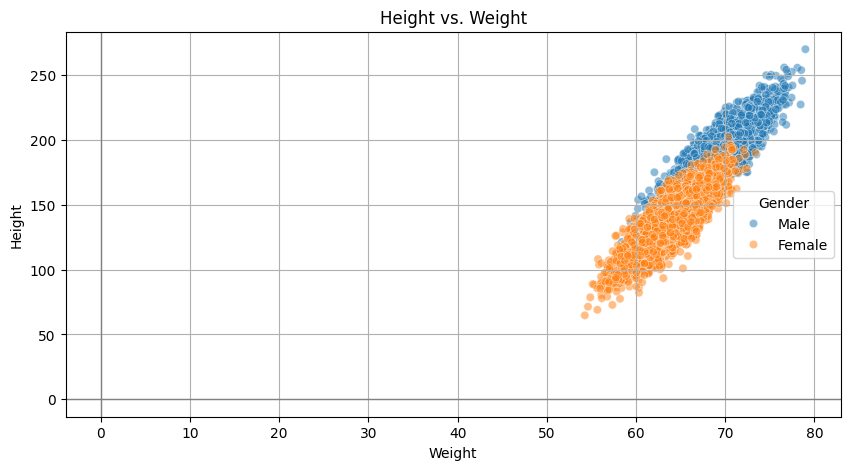

In [3]:
# Zero-Centering 데이터 시각화
plt.figure(figsize=(10, 5))

# 키와 몸무게의 Zero-Centered 데이터 분포
sns.scatterplot(x='Weight', y='Height', data=data, hue='Gender', alpha=0.5)
plt.title('Height vs. Weight')
plt.xlabel('Weight')
plt.ylabel('Height')
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.grid(True)

plt.show()


<a id="1-1"></a>
### Centering

In [4]:
mean_height = data['Height'].mean()
mean_weight = data['Weight'].mean()

data['Height_centered'] = data['Height'] - mean_height
data['Weight_centered'] = data['Weight'] - mean_weight

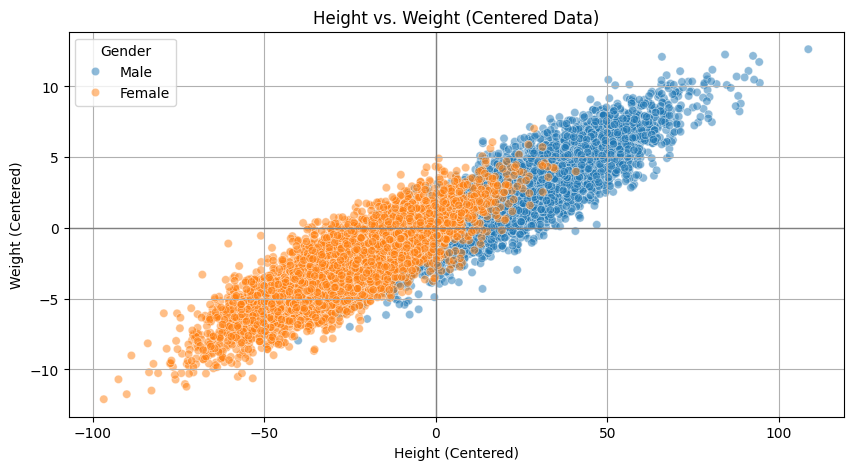

In [5]:
# Zero-Centering 데이터 시각화
plt.figure(figsize=(10, 5))

# 키와 몸무게의 Zero-Centered 데이터 분포
sns.scatterplot(x='Height_centered', y='Weight_centered', data=data, hue='Gender', alpha=0.5)
plt.title('Height vs. Weight (Centered Data)')
plt.ylabel('Weight (Centered)')
plt.xlabel('Height (Centered)')
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.grid(True)

plt.show()


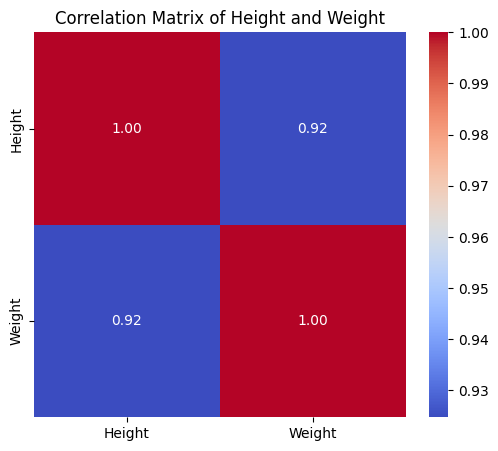

In [6]:
correlation_matrix = data[['Height', 'Weight']].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Height and Weight')
plt.show()


<a id="1-2"></a>
### 1-2.Normalization

Text(0.5, 0, 'Weight (Min-Max Normalized)')

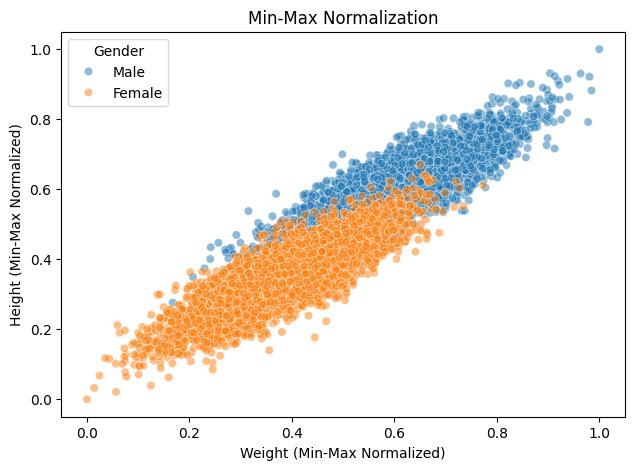

In [7]:
data['Height_min_max'] = (data['Height'] - data['Height'].min()) / (data['Height'].max() - data['Height'].min())
data['Weight_min_max'] = (data['Weight'] - data['Weight'].min()) / (data['Weight'].max() - data['Weight'].min())

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x='Weight_min_max', y='Height_min_max', data=data, hue='Gender', alpha=0.5)
plt.title('Min-Max Normalization')
plt.ylabel('Height (Min-Max Normalized)')
plt.xlabel('Weight (Min-Max Normalized)')

<a id="2"></a>
## 2. Weight Initialization

In [8]:
# 데이터셋 생성
X, Y = make_moons(n_samples=5000, noise=0.45, random_state=42)

# 데이터를 학습 및 테스트 세트로 분할
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2, random_state=42)

# Y 레이블을 (n, 1) 형태로 변환
train_y = train_y.reshape(-1, 1)
test_y = test_y.reshape(-1, 1)

# 넘파이 배열로 변환
train_x = train_x.T
train_y = train_y.T
test_x = test_x.T
test_y = test_y.T

# 데이터 형태 확인
print("train_x shape:", train_x.shape)
print("train_y shape:", train_y.shape)
print("test_x shape:", test_x.shape)
print("test_y shape:", test_y.shape)


train_x shape: (2, 4000)
train_y shape: (1, 4000)
test_x shape: (2, 1000)
test_y shape: (1, 1000)


<a id="2-1"></a>
### 2-1. 0으로 초기화

In [9]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)


def relu_derivative(x):
    return np.where(x > 0, 1, 0)

In [10]:
def initialize_parameters_zeros(layers_dims):
    ## zero initialization
    
    parameters = {}
    L = len(layers_dims) # number of layers in the network
    
    for l in range(1, L):
        parameters["W" + str(l)] = np.zeros((layers_dims[l], layers_dims[l-1]))
        parameters["b" + str(l)] = np.zeros((layers_dims[l], 1))
                
    return parameters

In [11]:
def forward_propagation(X, parameters):
    """
    Arguments:
     - X : input data (n_x, m) n_x는 feature 수, m은 데이터 샘플 수
     - parameters : 각 layer의 trainable params dict타입 {"W1", "b1", ..., "WL", "bL"}

    Returns:
     - AL : 출력층(L번째 layer)의 activation feature
     - caches : 각 층의 (input, weight, bias, output)
    """
    caches = []
    A = X
    L = len(parameters) // 2
    
    # [LINEAR -> RELU]*(L-1)
    for l in range(1, L):
        A_prev = A 
        W = parameters['W' + str(l)]
        b = parameters['b' + str(l)]
        Z = np.dot(W, A_prev) + b
        A = np.maximum(0, Z)  # ReLU
        cache = (A_prev, W, b, Z)
        caches.append(cache)
        
    # LINEAR -> SIGMOID
    WL = parameters['W' + str(L)]
    bL = parameters['b' + str(L)]
    ZL = np.dot(WL, A) + bL
    AL = 1 / (1 + np.exp(-ZL))  # Sigmoid
    cache = (A, WL, bL, ZL)
    caches.append(cache)
    
    assert(AL.shape == (1, X.shape[1]))
    
    return AL, caches

In [12]:
def compute_cost(AL, Y):
    """
    Arguments:
     - AL : label 예측에 해당하는 확률 벡터. (1, num of data samples)
     - Y : ground-truth 벡터. (1, num of data samples)

    Returns:
     - cost : cross-entropy cost
    """
    m = Y.shape[1]

    cost = (-1/m) * np.sum(Y * np.log(AL) + (1- Y) * np.log(1 - AL))
    cost = np.squeeze(cost)

    return cost

In [13]:
def relu_backward(dA, Z):
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0

    return dZ

def sigmoid_backward(dA, Z):
    S = sigmoid(Z)
    dZ = dA * S * (1-S)

    return dZ

def backward_propagation(X, Y, caches, AL):
    """
    Backward Propagation.
    L-1개의 [Linear -> ReLU] layer와 출력층 [Linear -> Sigmoid]의 parameter에 대한 gradient를 계산한다.

    Arguments:
     - X : 입력 데이터. (n_x, m) n_x는 feature 수, m은 데이터 샘플의 수
     - Y : ground_truth. (1, m)
     - caches : list 타입. 각 layer의 (input, weight, bias, output).
     - AL : 마지막 출력층의 출력값. y hat.
    """
    grads = {}
    L = len(caches) ## layer 수
    m = X.shape[1] ## 데이터 샘플의 수

    ## cost function gradient
    dAL = -(np.divide(Y, AL) - np.divide(1-Y, 1-AL))
    # dAL = -(np.divide(Y, AL + 1e-8) - np.divide(1 - Y, 1 - AL + 1e-8))

    ## L번째 layer(출력층) [sigmoid -> Linear] gradient
    cache = caches[-1]
    A_prev, WL, bL, ZL = cache
    dZL = sigmoid_backward(dAL, ZL) ## dL/dA * dA/dZ = dL / dZ
    dWL = np.dot(dZL, A_prev.T) ## dL/dZ * dZ/dW = dL/dW
    dbL = np.sum(dZL, axis=1, keepdims=True) / m ## dL/dZ * dZ/db = dL/db
    dA_prev = np.dot(WL.T, dZL) ## dL/dZ * dZ/dX = dL/dX

    grads["dA" + str(L)] = dA_prev
    grads["dW" + str(L)] = dWL
    grads["db" + str(L)] = dbL

    for l in reversed(range(L-1)):
        cache = caches[l]
        A_prev, W, b, Z = cache
        dZ = relu_backward(grads["dA" + str(l + 2)], Z)
        dW = np.dot(dZ, A_prev.T) / m
        db = np.sum(dZ, axis=1, keepdims=True) / m
        dA_prev = np.dot(W.T, dZ)

        grads["dA" + str(l + 1)] = dA_prev
        grads["dW" + str(l + 1)] = dW
        grads["db" + str(l + 1)] = db
    
    return grads

In [14]:
def update_parameters_with_gradient_descent(parameters, grads, learning_rate):
    """
    Gradient Descent 방식으로 parameter를 업데이트.

    Arguments:
     - parameters : dict 타입. layer에 설정된 weight, bias
     - grads : dict 타입. 각 parameter에 대한 gradients
     - learning rate : 실수형. 

    Returns:
     - parameters : dict 타입. gradient로 업데이트된 parameters
    """
    L = len(parameters) // 2 ## nn을 구성하는 layer 수

    for l in range(1, L + 1):
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads['dW' + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads['db' + str(l)]

    return parameters

In [15]:
def random_mini_batches(X, Y, mini_batch_size=64, seed=0):
    np.random.seed(seed)
    m = X.shape[1]
    mini_batches = []

    ## Shuffle
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1, m))

    num_mini_batches = math.floor(m / mini_batch_size)
    for k in range(0, num_mini_batches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : (k + 1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : (k + 1) * mini_batch_size]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    ## 마지막 미니배치의 크기가 batch_size와 다른 경우. 나머지 데이터들을 묶어서 미니 배치를 생성.
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_mini_batches * mini_batch_size:]
        mini_batch_Y = shuffled_Y[:, num_mini_batches * mini_batch_size:]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches

In [16]:
def model(X, Y, layers_dims, learning_rate=0.01, batch_size=64, num_epochs=5000, print_cost=True):
    """
    LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
     - X : input (feature의 수, 데이터 샘플의 수)
     - Y : ground-truth (1, 데이터 샘플의 수)
     - learning_rate
     - num_iterations : 학습 iteration 수.
     - print_cost : iteration마다 cost를 출력할 것인가?
     - initialization : weight initialization 방법 선택 ("zeros","random" or "he")
    
    Returns:
     - parameters : 학습된 parameter
     - costs : 학습동안 발생한 cost list
    """
    t = 0
    seed = 10
    grads = {}
    costs = []
    m = X.shape[1]    
    # parameters = initialize_parameters_he(layers_dims)
    parameters = initialize_parameters_zeros(layers_dims)

    for i in range(num_epochs):
        cost_total = 0
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, batch_size, seed)
        
        cost_total = 0
        for minibatch in minibatches:
            mini_batch_X, mini_batch_Y = minibatch

            # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
            AL, caches = forward_propagation(mini_batch_X, parameters)
        
            # Cost
            cost_total += compute_cost(AL, mini_batch_Y)

            # Backward propagation.
            grads = backward_propagation(mini_batch_X, mini_batch_Y, caches, AL)
        
            # Update parameters.
            parameters = update_parameters_with_gradient_descent(parameters, grads, learning_rate)
        
        cost_avg = cost_total / m
        # Print the loss every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

Cost after epoch 0: 0.010917
Cost after epoch 1000: 0.010916
Cost after epoch 2000: 0.010916
Cost after epoch 3000: 0.010915
Cost after epoch 4000: 0.010916


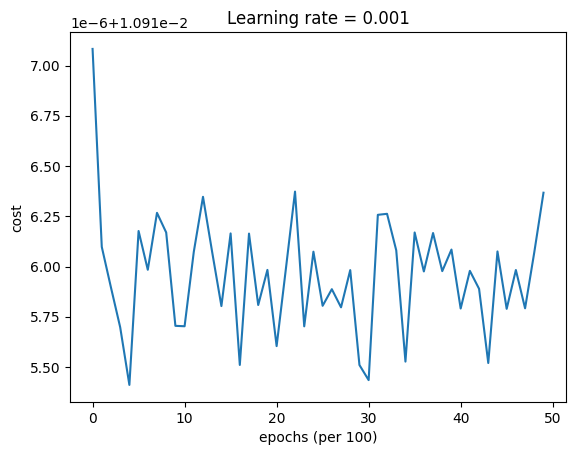

In [17]:
parameters = model(train_x, train_y, layers_dims=[train_x.shape[0], 4, 2, 1], learning_rate=0.001, batch_size=64, num_epochs=5000)

<a id="2-2"></a>
### 2-2. Random Initialization

In [18]:
def initialize_parameters_random(layers_dims):
    """
    Normal Distribution을 기반으로 랜덤값을 선정.

    Arguments:
     - layer_dims : 각 layer에 설정할 unit의 수. list 타입
    
    Returns:
     - parameters : 각 layer에 설정되는 weight(matrix, "W1", "W2",..."WL"), bias(vector, "b1", "b2",..."bL")의 dictionary 타입
                    W1 : weight matrix of shape (layers_dims[1], layers_dims[0])
                    b1 : bias vector of shape (layers_dims[1], 1)
                    ...
                    WL : weight matrix of shape (layers_dims[L], layers_dims[L-1])
                    bL : bias vector of shape (layers_dims[L], 1)
    """
    np.random.seed(3)

    parameters = {}
    L = len(layers_dims)
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
        
    return parameters

In [19]:
def model(X, Y, layers_dims, learning_rate=0.01, batch_size=64, num_epochs=5000, print_cost=True):
    """
    LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
     - X : input (feature의 수, 데이터 샘플의 수)
     - Y : ground-truth (1, 데이터 샘플의 수)
     - learning_rate
     - num_iterations : 학습 iteration 수.
     - print_cost : iteration마다 cost를 출력할 것인가?
     - initialization : weight initialization 방법 선택 ("zeros","random" or "he")
    
    Returns:
     - parameters : 학습된 parameter
     - costs : 학습동안 발생한 cost list
    """
    t = 0
    seed = 10
    grads = {}
    costs = []
    m = X.shape[1]    
    parameters = initialize_parameters_random(layers_dims)

    for i in range(num_epochs):
        cost_total = 0
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, batch_size, seed)
        
        cost_total = 0
        for minibatch in minibatches:
            mini_batch_X, mini_batch_Y = minibatch

            # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
            AL, caches = forward_propagation(mini_batch_X, parameters)
        
            # Cost
            cost_total += compute_cost(AL, mini_batch_Y)

            # Backward propagation.
            grads = backward_propagation(mini_batch_X, mini_batch_Y, caches, AL)
        
            # Update parameters.
            parameters = update_parameters_with_gradient_descent(parameters, grads, learning_rate)
        
        cost_avg = cost_total / m
        # Print the loss every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

Cost after epoch 0: 0.014262
Cost after epoch 1000: 0.006530
Cost after epoch 2000: 0.006332
Cost after epoch 3000: 0.006171
Cost after epoch 4000: 0.006153


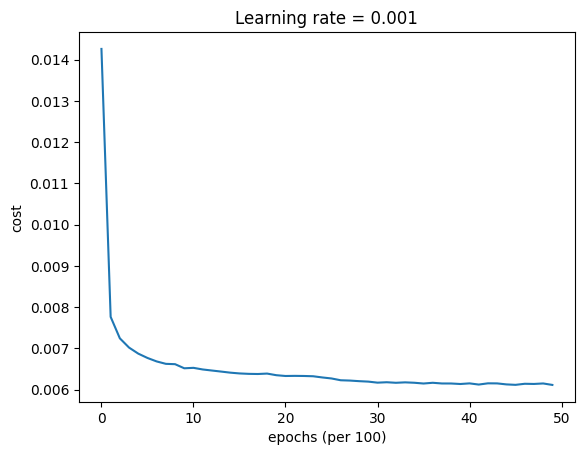

In [20]:
parameters = model(train_x, train_y, layers_dims=[train_x.shape[0], 4, 2, 1], learning_rate=0.001, batch_size=64, num_epochs=5000)

<a id="3"></a>
## 3. Xavier Initialization

In [21]:
def initialize_parameters_xavier(layers_dims):
    np.random.seed(3)
    parameters = {}
    L = len(layers_dims) - 1
    
    for l in range(1, L + 1):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * np.sqrt(1 / layers_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
                
    return parameters

In [22]:
def model(X, Y, layers_dims, learning_rate=0.01, batch_size=64, num_epochs=5000, print_cost=True):
    """
    LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
     - X : input (feature의 수, 데이터 샘플의 수)
     - Y : ground-truth (1, 데이터 샘플의 수)
     - learning_rate
     - num_iterations : 학습 iteration 수.
     - print_cost : iteration마다 cost를 출력할 것인가?
     - initialization : weight initialization 방법 선택 ("zeros","random" or "he")
    
    Returns:
     - parameters : 학습된 parameter
     - costs : 학습동안 발생한 cost list
    """
    t = 0
    seed = 10
    grads = {}
    costs = []
    m = X.shape[1]    
    parameters = initialize_parameters_xavier(layers_dims)

    for i in range(num_epochs):
        cost_total = 0
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, batch_size, seed)
        
        cost_total = 0
        for minibatch in minibatches:
            mini_batch_X, mini_batch_Y = minibatch

            # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
            AL, caches = forward_propagation(mini_batch_X, parameters)
        
            # Cost
            cost_total += compute_cost(AL, mini_batch_Y)

            # Backward propagation.
            grads = backward_propagation(mini_batch_X, mini_batch_Y, caches, AL)
        
            # Update parameters.
            parameters = update_parameters_with_gradient_descent(parameters, grads, learning_rate)
        
        cost_avg = cost_total / m
        # Print the loss every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

Cost after epoch 0: 0.012798
Cost after epoch 1000: 0.006413
Cost after epoch 2000: 0.006237
Cost after epoch 3000: 0.006183
Cost after epoch 4000: 0.006172


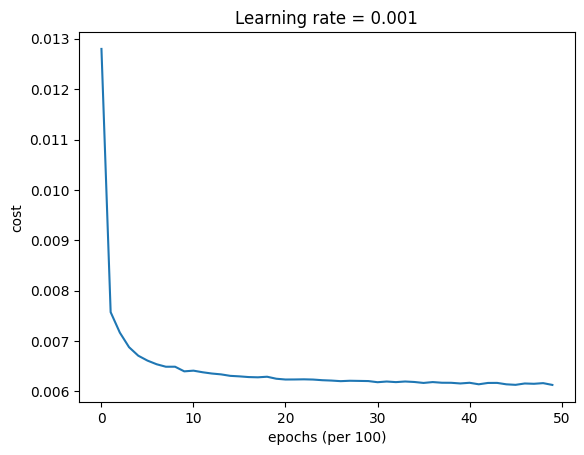

In [23]:
parameters = model(train_x, train_y, layers_dims=[train_x.shape[0], 4, 2, 1], learning_rate=0.001, batch_size=64, num_epochs=5000)

<a id="4"></a>
## 4. He Initialization

In [24]:
def initialize_parameters_he(layers_dims):  
    ## He Normal Distribution을 따라 확률 변수들에 확률을 부여하고, 랜덤으로 가중치 값을 선정.
    np.random.seed(3)
    parameters = {}
    L = len(layers_dims) - 1
     
    for l in range(1, L + 1):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * np.sqrt(2 / layers_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
                
    return parameters

In [25]:
def model(X, Y, layers_dims, learning_rate=0.01, batch_size=64, num_epochs=5000, print_cost=True):
    """
    LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
     - X : input (feature의 수, 데이터 샘플의 수)
     - Y : ground-truth (1, 데이터 샘플의 수)
     - learning_rate
     - num_iterations : 학습 iteration 수.
     - print_cost : iteration마다 cost를 출력할 것인가?
     - initialization : weight initialization 방법 선택 ("zeros","random" or "he")
    
    Returns:
     - parameters : 학습된 parameter
     - costs : 학습동안 발생한 cost list
    """
    t = 0
    seed = 10
    grads = {}
    costs = []
    m = X.shape[1]    
    parameters = initialize_parameters_he(layers_dims)

    for i in range(num_epochs):
        cost_total = 0
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, batch_size, seed)
        
        cost_total = 0
        for minibatch in minibatches:
            mini_batch_X, mini_batch_Y = minibatch

            # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
            AL, caches = forward_propagation(mini_batch_X, parameters)
        
            # Cost
            cost_total += compute_cost(AL, mini_batch_Y)

            # Backward propagation.
            grads = backward_propagation(mini_batch_X, mini_batch_Y, caches, AL)
        
            # Update parameters.
            parameters = update_parameters_with_gradient_descent(parameters, grads, learning_rate)
        
        cost_avg = cost_total / m
        # Print the loss every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

Cost after epoch 0: 0.014478
Cost after epoch 1000: 0.006489
Cost after epoch 2000: 0.006291
Cost after epoch 3000: 0.006230
Cost after epoch 4000: 0.006204


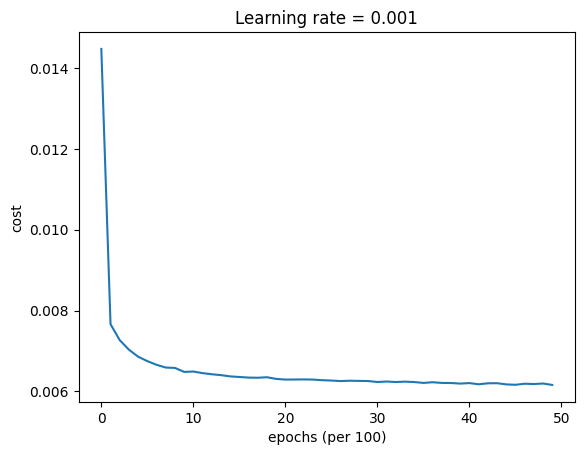

In [26]:
parameters = model(train_x, train_y, layers_dims=[train_x.shape[0], 4, 2, 1], learning_rate=0.001, batch_size=64, num_epochs=5000)